In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import DataReader
import numpy as np
from sklearn.linear_model import LinearRegression
import taguchimethod
from datetime import datetime
from pandas_datareader._utils import RemoteDataError
import time
import glob
import tqdm

In [46]:
class Load_data:
    def __init__(self, ticker):
        self.ticker = ticker
    def return_df(self):
        self.df = DataReader(self.ticker, "yahoo", start=datetime(2000, 1, 1))
        self.df = self.df.sort_index()
        self.df = self.df[self.df["Volume"] > 0]
        return self.df
    def add_MA(self, df, window_short=25, window_long=100, visible = False):
        self.df = df
        self.window_short = window_short
        self.window_long = window_long
        self.visible = visible
        
        self.df["MA_{}".format(int(self.window_short))] = self.df["Adj Close"].rolling(window=self.window_short).mean()
        self.df["MA_{}".format(int(self.window_long))] = self.df["Adj Close"].rolling(window=self.window_long).mean()
        
        if visible == True:
            plt.figure(figsize=(5, 5))
            plt.plot(self.df["Adj Close"], label="Original")
            plt.plot(self.df["MA_{}".format(int(self.window_short))], label="Short_MA(window={})".format(self.window_short))
            plt.plot(self.df["MA_{}".format(int(self.window_long))], label="Long_MA(window{})".format(self.window_long))
            plt.legend()
            plt.show()
        
        return self.df
    def add_Std(self, df, window = 25):
        self.df = df
        self.window=window
        self.df["Std"] = self.df["Adj Close"].rolling(window = self.window).std()
        return self.df

In [53]:
class Golden_Dead_Cross:
    def __init__(self, df):
        self.df = df
    def return_df(self, short, long):
        self.short = short
        self.long = long
        
        self.df["change%"] = self.df["Adj Close"].pct_change()
        self.df["Cross"] = 0
        self.df["Hold"] = 1
        self.df["Assets"] = 1.0
        self.k = 0
        for self.i in range(1, len(self.df)):
            #long>short:GOLDEN, long<short:Dead
            if self.df["MA_{}".format(self.short)].iat[self.i-1] < self.df["MA_{}".format(self.long)].iat[self.i-1] and \
               self.df["MA_{}".format(self.short)].iat[self.i] > self.df["MA_{}".format(self.long)].iat[self.i]:
                self.df["Cross"].iat[self.i] = 1#Buy at GoldenCross
                
            elif self.df["MA_{}".format(self.short)].iat[self.i-1] > self.df["MA_{}".format(self.long)].iat[self.i-1] and \
                 self.df["MA_{}".format(self.short)].iat[self.i] < self.df["MA_{}".format(self.long)].iat[self.i]:
                self.df["Cross"].iat[self.i] = -1#Sell at GoldenCross
                self.k += 1

            if self.k > 0:# num of buy > 0
                if self.df["Cross"].iat[self.i] == 1:
                    self.df["Hold"].iat[self.i] = 1
                elif self.df["Cross"].iat[self.i] == -1:
                    self.df["Hold"].iat[self.i] = 0
                else:
                    self.df["Hold"].iat[self.i] = self.df["Hold"].iat[self.i-1]
    
            if self.df["Hold"].iat[self.i] == 0:
                self.df["Assets"].iat[self.i] = self.df["Assets"].iat[self.i-1]
            else:
                self.df["Assets"].iat[self.i] = self.df["Assets"].iat[self.i-1]*(1+self.df["change%"].iat[self.i])
        return self.df

In [54]:
class Analytics:
    def __init__(self, df, ticker, short, long):
        self.df = df
        self.ticker = ticker
        self.short = short
        self.long = long
    def compute_rise_fall_rate(self):
        self.res_ = []
        for self.i in range(2000, 2021, 1):
            self.start = datetime(self.i, 1, 1)
            self.end = datetime(self.i, 12, 31)
            self.select_ = (self.df.index >= self.start) & (self.df.index <= self.end)
            if np.sum(self.select_) > 0:
                self.original_rise_fall_rate = self.df[self.select_]["Adj Close"].iat[-1]/self.df[self.select_]["Adj Close"].iat[0]
                self.assets_rise_fall_rate = self.df[self.select_]["Assets"].iat[-1]/self.df[self.select_]["Assets"].iat[0]
                self.hold_day = (self.df[self.select_]["Hold"] == 1).sum()
                self.original_total_rase_fall_rate = self.df["Adj Close"][-1]/self.df["Adj Close"][0]
                self.assets_total_rase_fall_rate = self.df["Assets"][-1]/self.df["Assets"][0]
                self.res_.append([self.ticker, self.short, self.long, self.i, self.original_rise_fall_rate, 
                                  self.assets_rise_fall_rate, self.hold_day, 
                                  self.original_total_rase_fall_rate, self.assets_total_rase_fall_rate])
        return self.res_

In [49]:
company_list = pd.read_csv("companylist.csv")

In [22]:
len(company_list["コード"])/8

504.75

In [23]:
list1 = company_list["コード"][504*0:504*1]
list2 = company_list["コード"][504*1:504*2]
list3 = company_list["コード"][504*2:504*3]
list4 = company_list["コード"][504*3:504*4]
list5 = company_list["コード"][504*4:504*5]
list6 = company_list["コード"][504*5:504*6]
list7 = company_list["コード"][504*6:504*7]
list8 = company_list["コード"][504*7:-1]

# create data

t = time.time()

for i in company_list["コード"]:
    master_df = pd.DataFrame()
    print("{:04d}.T".format(i))
    try:# proceed if ticker exists
        c = Load_data("{:04d}.T".format(i))
        for short in range(25, 55, 5):
            print(short)
            for long in range(75, 225, 25):
                res_ = []
                df = c.add_MA(df = c.return_df(), window_short=short, window_long=long, visible=False)
                df = Golden_Dead_Cross(df).return_df(short, long)
                res_ = Analytics(df = df, ticker=i, short=short, long=long).compute_rise_fall_rate()
                series_ = pd.DataFrame(res_, columns=["Code", "short", "long", 
                                                      "Year", "Original_rate_year", 
                                                      "Assets_rate_year", "hold_day_year", 
                                                      "Original_rate", "Assets_rate"])
                master_df = pd.concat([master_df, series_])
    
    
    
    except RemoteDataError:
        print("No ticker")
        pass
    master_df.to_csv("./Result/{}.csv".format(i), index=None)
    
    break

In [399]:
i = 6301
c = Load_data("{}.T".format(i))
short = 35
long = 75
res_ = []
df = c.add_MA(c.return_df(), short, long, visible=False)
df = Golden_Dead_Cross(df).return_df(short, long)
res_ = Analytics(df, i, short, long).compute_rise_fall_rate()
series_ = pd.DataFrame(res_, columns=["Code", "short", "long", 
                                      "Year", "Original_rate_year", 
                                      "Assets_rate_year", "hold_day_year", 
                                      "Original_rate", "Assets_rate"])

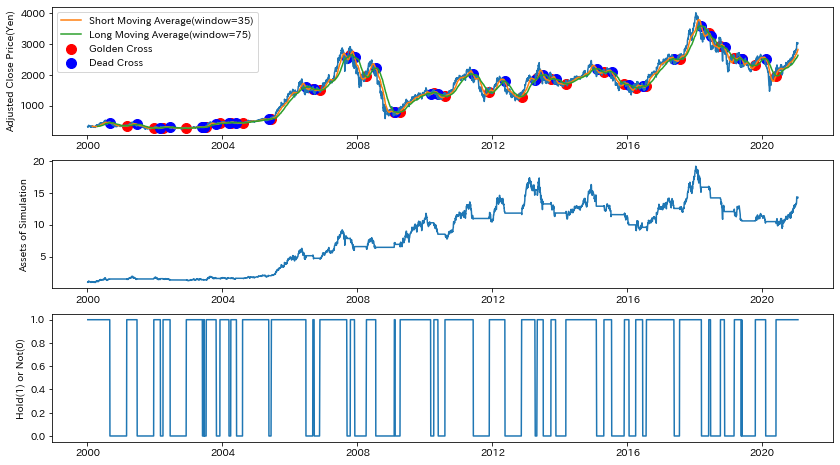

In [404]:
plt.figure(figsize=(14, 8))
plt.subplot(311)
plt.plot(df["Adj Close"])
plt.plot(df["MA_{}".format(short)], label="Short Moving Average(window={})".format(short))
plt.plot(df["MA_{}".format(long)], label="Long Moving Average(window={})".format(long))
plt.scatter(df[df["Cross"] == 1]["MA_{}".format(long)].index, 
            df[df["Cross"] == 1]["MA_{}".format(long)], s=100, c="red", label="Golden Cross")
plt.scatter(df[df["Cross"] == -1]["MA_{}".format(long)].index, 
            df[df["Cross"] == -1]["MA_{}".format(long)], s=100, c="blue", label="Dead Cross")
plt.legend()
plt.ylabel("Adjusted Close Price(Yen)")
plt.subplot(312)
plt.plot(df["Assets"])
plt.ylabel("Assets of Simulation")
plt.subplot(313)
plt.plot(df["Hold"])
plt.ylabel("Hold(1) or Not(0)")
plt.show()

# Summarize

In [398]:
sum_df = pd.DataFrame()
for i in tqdm.tqdm(glob.glob("./マルチ/Result/*csv")):
    sum_df = pd.concat([sum_df, pd.read_csv(i)])

temp = sum_df.groupby(["Code"]).min()

adj_over_zero = temp[temp.iloc[:, 3:].min(axis=1) >= 0].index
adj_under_zero = temp[temp.iloc[:, 3:].min(axis=1) < 0].index

use_list = [i for i in range(len(sum_df)) if sum_df["Code"].iat[i] in adj_over_zero]

sum_df = sum_df.iloc[use_list].reset_index(drop=True)

hyper_parameter_df = sum_df.groupby(["Code", "short", "long"]).mean()[["Original_rate", "Assets_rate"]].reset_index()

hyper_param_list = []
for i in range(25, 55, 5):
    for j in range(75, 225, 25):
        select_ = (hyper_parameter_df["short"] == i) & (hyper_parameter_df["long"] == j)
        OR = hyper_parameter_df[select_]["Original_rate"].values
        AR = hyper_parameter_df[select_]["Assets_rate"].values
        hyper_param_list.append([i, j, OR, AR])

100%|██████████████████████████████████████████████████████████████████████████████| 1365/1365 [01:23<00:00, 16.34it/s]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


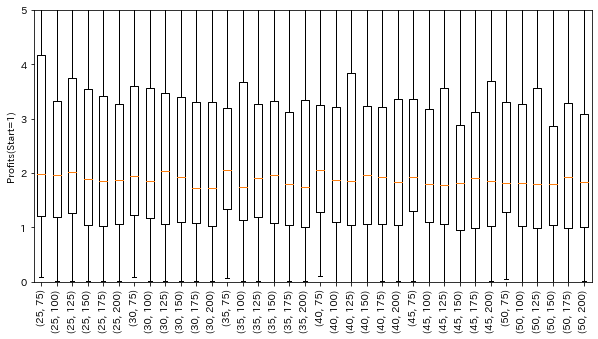

In [409]:
plt.figure(figsize=(10, 5))
plt.boxplot( np.array(hyper_param_list)[:, 3] , labels=[(np.array(hyper_param_list)[:, 0:2][i][0] , np.array(hyper_param_list)[:, 0:2][i][1]) for i in range(len(hyper_param_list))])
plt.xticks(rotation=90)
plt.ylim(0, 5)
plt.ylabel("Profits(Start=1)")
plt.show()

In [410]:
np.argsort( [-np.median( np.array(hyper_param_list)[:, 3][i] ) for i in range(len(hyper_param_list))] )

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


array([18, 12,  8,  2,  0, 21, 15,  1,  6,  9, 24, 22, 34, 28, 14,  3, 19,
        5, 20,  4, 29,  7, 35, 23, 30, 27, 31, 33, 16, 32, 25, 26, 13, 17,
       10, 11], dtype=int64)

In [411]:
select_ = (sum_df["short"] == 35) & (sum_df["long"] == 75)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


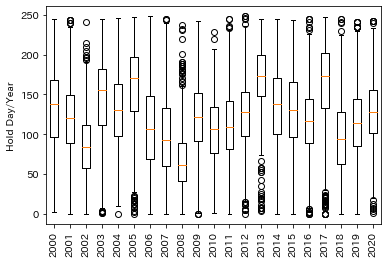

In [412]:
plt.boxplot([sum_df[(sum_df["Year"] == i) & select_]["hold_day_year"] for i in range(2000, 2021, 1)], 
           labels=np.arange(2000, 2021, 1))
plt.xticks(rotation=90)
plt.ylabel("Hold Day/Year")
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


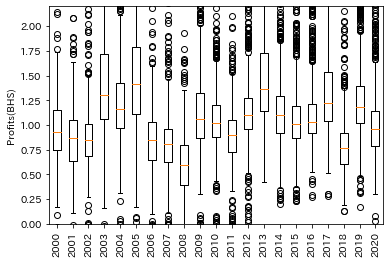

In [422]:
plt.boxplot([sum_df[(sum_df["Year"] == i) & select_]["Original_rate_year"] for i in range(2000, 2021, 1)], 
           labels=np.arange(2000, 2021, 1))
plt.xticks(rotation=90)
plt.ylim(0, 2.2)
plt.ylabel("Profits(BHS)")
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


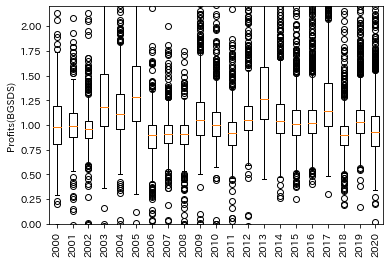

In [423]:
plt.boxplot([sum_df[(sum_df["Year"] == i) & select_]["Assets_rate_year"] for i in range(2000, 2021, 1)], 
           labels=np.arange(2000, 2021, 1))
plt.xticks(rotation=90)
plt.ylim(0, 2.2)
plt.ylabel("Profits(BGSDS)")
plt.show()

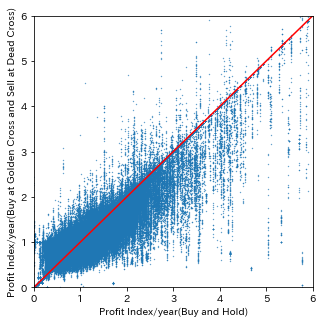

In [416]:
plt.figure(figsize=(5, 5))
plt.scatter(sum_df["Original_rate_year"], sum_df["Assets_rate_year"], s=.1)
plt.plot([0, 6], [0, 6], c="red")
plt.xlim(0 , 6)
plt.ylim(0 , 6)
plt.xlabel("Profit Index/year(Buy and Hold)")
plt.ylabel("Profit Index/year(Buy at Golden Cross and Sell at Dead Cross)")
plt.show()

In [417]:
np.sum( sum_df["Original_rate_year"] >= sum_df["Assets_rate_year"] )

369162

In [418]:
len(sum_df)

639265

In [421]:
np.sum( sum_df["Original_rate_year"] >= sum_df["Assets_rate_year"] )/len(sum_df)

0.5774788233361752

In [419]:
possibility = []
for i in range(2000, 2021, 1):
    possibility.append([i , np.sum( sum_df[sum_df["Year"] == i]["Original_rate_year"] >= sum_df[sum_df["Year"] == i]["Assets_rate_year"] )/np.sum(sum_df["Year"] == i)])

In [429]:
len(np.arange(2000, 2021, 1))

21

In [428]:
len(np.array(possibility)[: , 1])

21

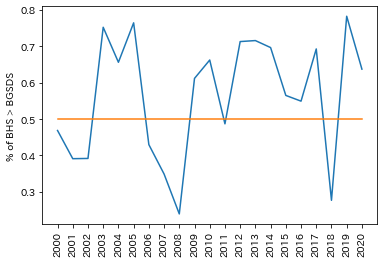

In [445]:
plt.plot( ["{}".format(i) for i in  np.arange(2000, 2021, 1)] , np.array(possibility)[: , 1] )
plt.plot(["2000", "2020"], [0.5, 0.5])
plt.xticks(rotation=90)
plt.ylabel("% of BHS > BGSDS")
plt.show()